In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import data.atnf
plt.style.use('ggplot')

In [2]:
import timingarray

In [3]:
array = timingarray.TimingArray()

In [4]:
array.effective_pairs()

36.291987559103973

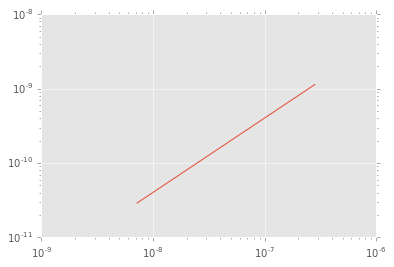

In [8]:
plt.loglog(frequencies, np.sqrt(array.effective_psd()))

In [175]:
array.pulsars[0].p_vector

<Quantity [ 0.98761769, 0.13202488, 0.0847392 ]>

In [174]:
pipj = np.outer(array.pulsars[0].p_vector, array.pulsars[0].p_vector)

In [177]:
def omega(phi, theta):
    return np.dot(np.dot(e, rot_z(phi)), rot_x(theta))

In [21]:
def rot_z(phi):
    return np.array([
            [np.cos(phi), -np.sin(phi), 0],
            [np.sin(phi), np.cos(phi), 0],
            [0,0,1]
        ])

def rot_y(psi):
    return np.array([
            [np.cos(phi), 0,  -np.sin(phi)],
            [0, 1,   0],
            [np.sin(phi),           0,             np.cos(phi)]
        ])

def rot_x(theta):
    return np.array([
            [1,             0,              0],
            [0, np.cos(theta), -np.sin(theta)],
            [0, np.sin(theta),  np.cos(theta)]
        ])

import scipy.integrate as integrate

In [245]:
def antenna_pattern(i, theta, phi, psi):
    fplus = 0
    fcross = 0
    pipj = np.outer(array.pulsars[i].p_vector, array.pulsars[i].p_vector)
    # The unrotated basis of the gravitational wave
    e = np.array([
        [1,0,0],
     #   [0,1,0],
     #   [0,0,1]
    ]).T
    # Calculate the rotated basis
    # Rotate phi about z
    # Rotate theta about x
    # Rotate psi about z
    #rot_basis = np.dot(np.dot(np.dot(np.dot(dhat,rot_x(theta)), rot_z(phi)), rot_z(psi)), e)
    rot_basis = np.dot( np.dot( rot_x(theta), rot_z(phi)), e)

    def plus_polarisation(psi, rot_basis):
        alpha, beta, _ = rot_basis
        rot_basis = np.dot(rot_basis, rot_z(psi))
        return np.outer(alpha, alpha) - np.outer(beta, beta)
    def cross_polarisation(psi, rot_basis):
        alpha, beta, _ = rot_basis
        ot_basis = np.dot(rot_basis, rot_z(psi))
        return np.outer(alpha, beta) + np.outer(beta, alpha)

    fplus  = plus_polarisation(psi, e)
    fcross = cross_polarisation(psi, e)

    #return np.abs(fplus), np.abs(fcross)
    
    return np.tensordot(fplus,pipj / (2*(1 + np.dot(rot_basis,array.pulsars[i].p_vector))), np.tensordot(fcross, pipj / (2*(1 + np.dot(rot_basis,array.pulsars[i].p_vector)))))

In [246]:
def skymap(p, nx=200, ny=100, psi=[0, np.pi]):
    x = np.linspace(0, np.pi, ny)
    y = np.linspace(0, 2*np.pi, nx)
    xv, yv = np.meshgrid(x,y)

    H = np.zeros((nx, ny))
    A = np.zeros((nx, ny))
    B = np.zeros((nx, ny))

    #for p in range(len(array.pulsars)):
    for i in range(nx):
        for j in range(ny): 
            A[i,j], B[i,j] = antenna_pattern(p, xv[i,j], yv[i,j], psi)
    return x,y,A,B

In [247]:
x,y,A,B = skymap( 0, psi=0)
x,y,C,D = skymap(10, psi=0)

ValueError: shapes (3,1) and (3,3) not aligned: 1 (dim 1) != 3 (dim 0)

In [234]:
A*C + B*D

array([[ 0.04716706,  0.04688513,  0.04658816, ...,  0.03131773,
         0.03224431,  0.03312269],
       [ 0.04862011,  0.04833383,  0.04803194, ...,  0.03221305,
         0.03311419,  0.03397065],
       [ 0.05005981,  0.0497686 ,  0.04946121, ...,  0.0330258 ,
         0.03390403,  0.03474106],
       ..., 
       [ 0.04423999,  0.04396506,  0.04367622, ...,  0.02931454,
         0.03029985,  0.03122958],
       [ 0.04570557,  0.04542742,  0.04513479, ...,  0.03034879,
         0.03130341,  0.0322062 ],
       [ 0.04716706,  0.04688513,  0.04658816, ...,  0.03131773,
         0.03224431,  0.03312269]])

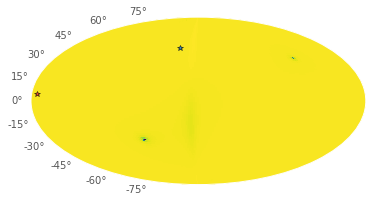

In [241]:
plt.style.use('ggplot')
ax = plt.subplot(111, projection="hammer")
plt.pcolormesh(y-np.pi,x-np.pi/2., (A*C).T, cmap='viridis')
#plt.colorbar(orientation='horizontal')
plt.plot(array.pulsars[0].location.ra.to(u.radian)-np.pi*u.radian, array.pulsars[0].location.dec.to(u.radian)*u.radian, '*')
plt.plot(array.pulsars[10].location.ra.to(u.radian)-np.pi*u.radian, array.pulsars[10].location.dec.to(u.radian)*u.radian, '*')

In [9]:
def overlap_reduction(frequencies, pulsar1, pulsar2):
    return (2*np.pi*frequencies)**(-2) * (1./3) * hellingsdowns_factor(pulsar1, pulsar2)

In [121]:
def overlap_reduction_f(frequency):
    """
    Calculate the overlap reduction matrix for the array at a given frequency.
    
    Parameters
    ----------
    frequency: float
        The frequency to evaluate the function at.
        
    Returns
    -------
    overlap matrix : ndarray
        The matrix of all of the overlap functions.
    """
    #hdmat = self.hdmatrix()
    olmat = np.zeros((len(array.pulsars), len(array.pulsars)))
    frequencies = 1e-8# np.logspace(-9, -6)
    olmat = (2*np.pi*frequencies)**(-2) * (1./3) * hdmat

In [128]:
hdmat

array([[        nan,  0.45007009,  0.15114577, ...,  0.2184633 ,
         0.36312337,  0.33915049],
       [ 0.45007009,         nan,  0.095302  , ...,  0.15423437,
         0.29374606,  0.25640638],
       [ 0.15114577,  0.095302  ,         nan, ...,  0.1243839 ,
         0.12991331,  0.16670939],
       ..., 
       [ 0.2184633 ,  0.15423437,  0.1243839 , ...,         nan,
         0.40135718,  0.42756601],
       [ 0.36312337,  0.29374606,  0.12991331, ...,  0.40135718,
                nan,  0.47744309],
       [ 0.33915049,  0.25640638,  0.16670939, ...,  0.42756601,
         0.47744309,         nan]])

In [127]:
np.sum(hdmat**2)

nan

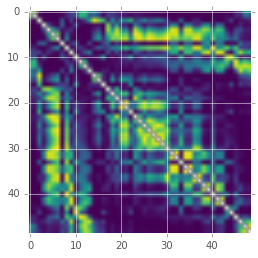

In [125]:
plt.imshow(olmat**2, cmap='viridis')

In [120]:
(2*np.pi*frequencies)**(-2) * (1./3) * hdmat

array([[             nan,   3.80013620e+13,   1.27618905e+13, ...,
          1.84458005e+13,   3.06600747e+13,   2.86359408e+13],
       [  3.80013620e+13,              nan,   8.04675965e+12, ...,
          1.30226745e+13,   2.48022487e+13,   2.16494981e+13],
       [  1.27618905e+13,   8.04675965e+12,              nan, ...,
          1.05022702e+13,   1.09691417e+13,   1.40759937e+13],
       ..., 
       [  1.84458005e+13,   1.30226745e+13,   1.05022702e+13, ...,
                     nan,   3.38883204e+13,   3.61012453e+13],
       [  3.06600747e+13,   2.48022487e+13,   1.09691417e+13, ...,
          3.38883204e+13,              nan,   4.03125825e+13],
       [  2.86359408e+13,   2.16494981e+13,   1.40759937e+13, ...,
          3.61012453e+13,   4.03125825e+13,              nan]])

In [7]:
pulsar1 = Pulsar('J0007+7303')
pulsar2 = Pulsar('J0014+4746')

In [8]:
hellingsdowns_factor(pulsar1, pulsar2)

<Quantity 0.3180132738182934>

In [12]:
ipta_list =  ascii.read("IPTA-pulsars.dat", delimiter=" ", guess=False)

In [13]:
atnf = data.atnf.get_atnf()

In [14]:
from astropy.table import Table, join

In [15]:
ipta_whole = join(ipta_list, atnf, keys='Name')

In [16]:
ipta_whole

Name,Timespan,MJDRange,RMSRes,ToAs,Cadence,Telescopes,DMVariance,Noise,#,PSRJ,RAJ,DECJ,POSEPOCH,F0,F1,F2,PEPOCH,DM,DIST,W50,W10,S400,S1400,SPINDX,PSRTYPE,NGLT,POS
,,,,,,,,,,,hourangle,deg,,Hz,Hz / s,Hz / s2,,pc / cm3,kpc,ms,ms,,,,,,"deg,deg"
str12,float64,str11,float64,int64,float64,int64,str12,str12,int64,str12,str10,str11,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str25,float64,object
J0030+0451,12.7,51275-55924,1.9,1250,6.6,3,Undetermined,Undetermined,29,J0030+0451,00:30:27.4,+04:51:39.7,54997.0,205.530699,-4.298e-16,--,50984.4,4.33,0.3,--,--,7.9,0.6,-2.6,"HE[btlb00,aaa+09e]",--,"7.61416666667,4.86102777778"
J0034-0534,11.1,51770-55808,4.4,267,24.0,2,y,n,32,J0034-0534,00:34:21.8,-05:34:36.6,50690.0,532.71343,-1.409e-15,-3.5e-26,50690.0,13.77,0.98,0.8,1.1,17.0,0.61,-2.3,HE[aaa+10b],--,"8.59083333333,-5.57683333333"
J0218+4232,15.2,50370-55924,6.7,1005,7.6,4,y,n,86,J0218+4232,02:18:06.3,+42:32:17.3,55849.1,430.461066,-1.434e-14,2.8e-26,50864.0,61.25,3.15,--,--,57.7,0.9,-2.1,"HE[khvb98,aaa+09f]",--,"34.52625,42.5381388889"
J0437-4715,14.9,50190-55619,0.3,5052,5.1,1,y,s,133,J0437-4715,04:37:15.8,-47:15:09.1,54500.0,173.687946,-1.728e-15,--,54500.0,2.64,0.16,0.141,1.02,550.0,149.0,-1.1,"HE[bt93,aaa+09f]",--,"69.3158333333,-47.2525277778"
J0610-2100,4.5,54270-55925,5.2,347,10.9,2,n,n,199,J0610-2100,06:10:13.5,-21:00:28.0,53100.0,258.978479,-8.283e-16,--,53100.0,60.67,5.64,0.2,1.8,--,0.4,--,HE[egc+13],--,"92.55625,-21.0077777778"
J0613-0200,13.7,50931-55926,1.2,2940,4.3,6,y,y,203,J0613-0200,06:13:43.9,-02:00:47.2,54500.0,326.600562,-1.023e-15,--,54500.0,38.78,1.09,0.462,0.92,21.0,2.3,-1.8,HE,--,"93.4329166667,-2.01311111111"
J0621+1002,14.3,50693-55921,11.5,637,10.6,4,y,y,209,J0621+1002,06:21:22.1,+10:02:38.7,50944.0,34.657407,-5.684e-17,--,50944.0,36.6,1.88,9.15,--,--,1.9,-1.9,--,--,"95.3420833333,10.0440833333"
J0711-6830,17.1,49373-55619,2.0,549,18.2,1,y,n,243,J0711-6830,07:11:54.1,-68:30:47.4,54500.0,182.117235,-4.944e-16,--,54500.0,18.41,1.04,1.092,2.57,10.0,3.2,-1.7,--,--,"107.975416667,-68.5131666667"


In [11]:
from astropy.io import ascii

In [36]:
#rdr = ascii.get_reader(Reader=ascii.Basic)
#rdr.header.splitter.delimiter = ' '
ipta_list = ascii.read("IPTA-pulsars.dat", delimiter=" ", guess=False)
ipta_list.add_index('Name')

In [10]:
import astropy.units as u

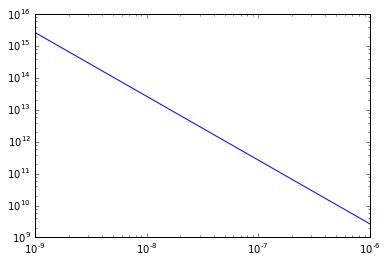

In [13]:
frequencies = np.logspace(-9,-6)
plt.loglog(frequencies, 
           overlap_reduction(frequencies, 
                             pulsar1, pulsar2)
          )